# Guest Blog: 10 minutes from pandas to Koalas

## Migration from pandas to Koalas

### Object creation

In [1]:
import numpy as np
import pandas as pd
import databricks.koalas as ks

In [2]:
# Create a pandas Series
pser = pd.Series([1, 3, 5, np.nan, 6, 8]) 
# Create a Koalas Series
kser = ks.Series([1, 3, 5, np.nan, 6, 8])
# Create a Koalas Series by passing a pandas Series
kser = ks.Series(pser)
kser = ks.from_pandas(pser)

In [3]:
pser

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

In [4]:
kser

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
Name: 0, dtype: float64

In [5]:
kser.sort_index()

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
Name: 0, dtype: float64

In [6]:
# Create a pandas DataFrame
pdf = pd.DataFrame({'A': np.random.rand(5),
                    'B': np.random.rand(5)})
# Create a Koalas DataFrame
kdf = ks.DataFrame({'A': np.random.rand(5),
                    'B': np.random.rand(5)})
# Create a Koalas DataFrame by passing a pandas DataFrame
kdf = ks.DataFrame(pdf)
kdf = ks.from_pandas(pdf)

In [7]:
pdf

,A,B
0,0.697803,0.355912
1,0.444441,0.617695
2,0.515603,0.314800
3,0.606602,0.896596
4,0.156260,0.996947


In [8]:
kdf.sort_index()

,A,B
0,0.697803,0.355912
1,0.444441,0.617695
2,0.515603,0.314800
3,0.606602,0.896596
4,0.156260,0.996947


### Viewing data

In [9]:
kdf.head(2)

,A,B
0,0.697803,0.355912
1,0.444441,0.617695


In [10]:
kdf.describe()

,A,B
count,5.000000,5.000000
mean,0.484142,0.636390
std,0.206591,0.308280
min,0.156260,0.314800
25%,0.444441,0.355912
50%,0.515603,0.617695
75%,0.606602,0.896596
max,0.697803,0.996947


In [11]:
kdf.sort_values(by='B')

,A,B
2,0.515603,0.314800
0,0.697803,0.355912
1,0.444441,0.617695
3,0.606602,0.896596
4,0.156260,0.996947


In [12]:
kdf.transpose()

,0,1,2,3,4
A,0.697803,0.444441,0.515603,0.606602,0.156260
B,0.355912,0.617695,0.314800,0.896596,0.996947


In [13]:
from databricks.koalas.config import set_option, get_option
ks.get_option('compute.max_rows')

1000

In [14]:
ks.set_option('compute.max_rows', 2000)
ks.get_option('compute.max_rows')

2000

### Selection

In [15]:
kdf['A']  # or kdf.A

0    0.697803
1    0.444441
2    0.515603
3    0.606602
4    0.156260
Name: A, dtype: float64

In [16]:
kdf[['A', 'B']]

,A,B
0,0.697803,0.355912
1,0.444441,0.617695
2,0.515603,0.314800
3,0.606602,0.896596
4,0.156260,0.996947


In [17]:
kdf.loc[1:2]

,A,B
1,0.444441,0.617695
2,0.515603,0.314800


In [18]:
kdf.iloc[:3, 1:2]

,B
0,0.355912
1,0.617695
2,0.314800


In [19]:
kser = ks.Series([100, 200, 300, 400, 500], index=[0, 1, 2, 3, 4])
# The below commented line will fail since Koalas disallows adding columns coming from
# different DataFrames or Series to a Koalas DataFrame as adding columns requires
# join operations which are generally expensive.
# This operation can be enabled by setting compute.ops_on_diff_frames to True.
# If you want to know about more detail, See the following blog post.
# https://databricks.com/blog/2020/03/31/10-minutes-from-pandas-to-koalas-on-apache-spark.html
# kdf['C'] = kser

In [20]:
# Those are needed for managing options
from databricks.koalas.config import set_option, reset_option
set_option("compute.ops_on_diff_frames", True)
kdf['C'] = kser
# Reset to default to avoid potential expensive operation in the future
reset_option("compute.ops_on_diff_frames")
kdf

,A,B,C
0,0.697803,0.355912,100
1,0.444441,0.617695,200
3,0.606602,0.896596,400
2,0.515603,0.314800,300
4,0.156260,0.996947,500


### Applying Python function with Koalas object

In [21]:
kdf.apply(np.cumsum)

,A,B,C
0,0.697803,0.355912,100
1,1.142244,0.973607,300
3,1.748846,1.870203,700
2,2.264449,2.185003,1000
4,2.420708,3.181950,1500


In [22]:
kdf.apply(np.cumsum, axis=1)

,A,B,C
0,0.697803,1.053715,101.053715
1,0.444441,1.062136,201.062136
3,0.606602,1.503198,401.503198
2,0.515603,0.830403,300.830403
4,0.156260,1.153207,501.153207


In [23]:
kdf.apply(lambda x: x ** 2)

,A,B,C
0,0.486929,0.126673,10000
1,0.197528,0.381547,40000
3,0.367966,0.803885,160000
2,0.265846,0.099099,90000
4,0.024417,0.993904,250000


In [24]:
def square(x) -> ks.Series[np.float64]:
    return x ** 2

In [25]:
kdf.apply(square)

,A,B,C
0,0.265846,0.099099,90000.0
1,0.024417,0.993904,250000.0
2,0.486929,0.126673,10000.0
3,0.367966,0.803885,160000.0
4,0.197528,0.381547,40000.0


In [26]:
# Working properly since size of data <= compute.shortcut_limit (1000)
ks.DataFrame({'A': range(1000)}).apply(lambda col: col.max())

A    999
Name: 0, dtype: int64

In [27]:
# Not working properly since size of data > compute.shortcut_limit (1000)
ks.DataFrame({'A': range(1001)}).apply(lambda col: col.max())

A     165
A     580
A     331
A     497
A     829
A     414
A     746
A     663
A     912
A    1000
A     248
A      82
Name: 0, dtype: int64

In [28]:
ks.set_option('compute.shortcut_limit', 1001)
ks.DataFrame({'A': range(1001)}).apply(lambda col: col.max())

A    1000
Name: 0, dtype: int64

### Grouping Data

In [29]:
kdf.groupby('A').sum()

,B,C
A,,
0.444441,0.617695,200
0.697803,0.355912,100
0.156260,0.996947,500
0.606602,0.896596,400
0.515603,0.314800,300


In [30]:
kdf.groupby(['A', 'B']).sum()

,,C
A,B,
0.697803,0.355912,100
0.606602,0.896596,400
0.515603,0.314800,300
0.156260,0.996947,500
0.444441,0.617695,200


### Plotting

In [31]:
# This is needed for visualizing plot on notebook
%matplotlib inline

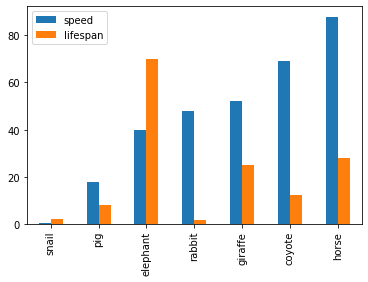

In [32]:
speed = [0.1, 17.5, 40, 48, 52, 69, 88]
lifespan = [2, 8, 70, 1.5, 25, 12, 28]
index = ['snail', 'pig', 'elephant',
         'rabbit', 'giraffe', 'coyote', 'horse']
kdf = ks.DataFrame({'speed': speed,
                   'lifespan': lifespan}, index=index)
kdf.plot.bar()

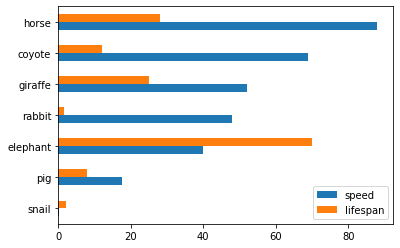

In [33]:
kdf.plot.barh()

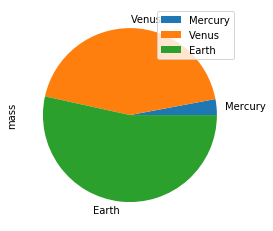

In [34]:
kdf = ks.DataFrame({'mass': [0.330, 4.87, 5.97],
                    'radius': [2439.7, 6051.8, 6378.1]},
                   index=['Mercury', 'Venus', 'Earth'])
kdf.plot.pie(y='mass')

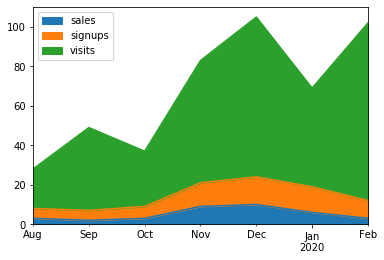

In [35]:
kdf = ks.DataFrame({
    'sales': [3, 2, 3, 9, 10, 6, 3],
    'signups': [5, 5, 6, 12, 14, 13, 9],
    'visits': [20, 42, 28, 62, 81, 50, 90],
}, index=pd.date_range(start='2019/08/15', end='2020/03/09',
                       freq='M'))
kdf.plot.area()

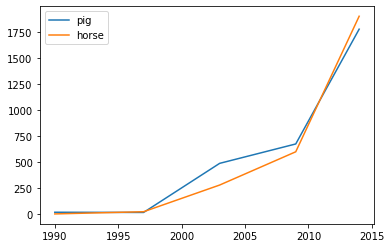

In [36]:
kdf = ks.DataFrame({'pig': [20, 18, 489, 675, 1776],
                    'horse': [4, 25, 281, 600, 1900]},
                   index=[1990, 1997, 2003, 2009, 2014])
kdf.plot.line()

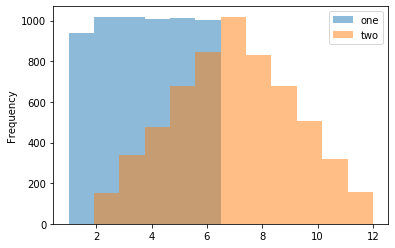

In [37]:
kdf = pd.DataFrame(
    np.random.randint(1, 7, 6000),
    columns=['one'])
kdf['two'] = kdf['one'] + np.random.randint(1, 7, 6000)
kdf = ks.from_pandas(kdf)
kdf.plot.hist(bins=12, alpha=0.5)

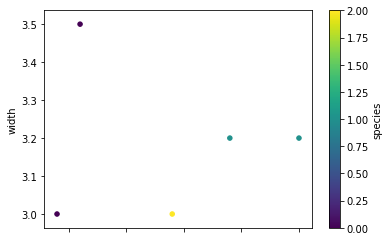

In [38]:
kdf = ks.DataFrame([[5.1, 3.5, 0], [4.9, 3.0, 0], [7.0, 3.2, 1],
                    [6.4, 3.2, 1], [5.9, 3.0, 2]],
                   columns=['length', 'width', 'species'])
kdf.plot.scatter(x='length',
                 y='width',
                 c='species',
                 colormap='viridis')

## Missing Functionalities and Workarounds in Koalas

### Directly use pandas APIs through type conversion

In [39]:
kidx = kdf.index

In [40]:
# Index.to_list() raises PandasNotImplementedError.
# Koalas does not support this because it requires collecting all data into the client
# (driver node) side. A simple workaround is to convert to pandas using to_pandas().
# If you want to know about more detail, See the following blog post.
# https://databricks.com/blog/2020/03/31/10-minutes-from-pandas-to-koalas-on-apache-spark.html
# kidx.to_list()

In [41]:
kidx.to_pandas().to_list()

[0, 1, 2, 3, 4]

### Native Support for pandas Objects

In [42]:
kdf = ks.DataFrame({'A': 1.,
                    'B': pd.Timestamp('20130102'),
                    'C': pd.Series(1, index=list(range(4)), dtype='float32'),
                    'D': np.array([3] * 4, dtype='int32'),
                    'F': 'foo'})

In [43]:
kdf

,A,B,C,D,F
0,1.0,2013-01-02,1.0,3,foo
1,1.0,2013-01-02,1.0,3,foo
2,1.0,2013-01-02,1.0,3,foo
3,1.0,2013-01-02,1.0,3,foo


### Distributed execution for pandas functions

In [44]:
i = pd.date_range('2018-04-09', periods=2000, freq='1D1min')
ts = ks.DataFrame({'A': ['timestamp']}, index=i)

# DataFrame.between_time() is not yet implemented in Koalas.
# A simple workaround is to convert to a pandas DataFrame using to_pandas(),
# and then applying the function.
# If you want to know about more detail, See the following blog post.
# https://databricks.com/blog/2020/03/31/10-minutes-from-pandas-to-koalas-on-apache-spark.html
# ts.between_time('0:15', '0:16')

In [45]:
ts.to_pandas().between_time('0:15', '0:16')

,A
2018-04-24 00:15:00,timestamp
2018-04-25 00:16:00,timestamp
2022-04-04 00:15:00,timestamp
2022-04-05 00:16:00,timestamp


In [46]:
ts.map_in_pandas(func=lambda pdf: pdf.between_time('0:15', '0:16'))

,A
2022-04-04 00:15:00,timestamp
2022-04-05 00:16:00,timestamp
2018-04-24 00:15:00,timestamp
2018-04-25 00:16:00,timestamp


### Using SQL in Koalas

In [47]:
kdf = ks.DataFrame({'year': [1990, 1997, 2003, 2009, 2014],
                    'pig': [20, 18, 489, 675, 1776],
                    'horse': [4, 25, 281, 600, 1900]})

In [48]:
ks.sql("SELECT * FROM {kdf} WHERE pig > 100")

,year,pig,horse
0,2003,489,281
1,2009,675,600
2,2014,1776,1900


In [49]:
pdf = pd.DataFrame({'year': [1990, 1997, 2003, 2009, 2014],
                    'sheep': [22, 50, 121, 445, 791],
                    'chicken': [250, 326, 589, 1241, 2118]})

In [50]:
ks.sql('''
    SELECT ks.pig, pd.chicken
    FROM {kdf} ks INNER JOIN {pdf} pd
    ON ks.year = pd.year
    ORDER BY ks.pig, pd.chicken''')

,pig,chicken
0,18,326
1,20,250
2,489,589
3,675,1241
4,1776,2118


## Working with PySpark

### Conversion from and to PySpark DataFrame

In [51]:
kdf = ks.DataFrame({'A': [1, 2, 3, 4, 5], 'B': [10, 20, 30, 40, 50]})
sdf = kdf.to_spark()
type(sdf)

pyspark.sql.dataframe.DataFrame

In [52]:
sdf.show()

+---+---+
|  A|  B|
+---+---+
|  1| 10|
|  2| 20|
|  3| 30|
|  4| 40|
|  5| 50|
+---+---+



In [53]:
from databricks.koalas import option_context
with option_context(
        "compute.default_index_type", "distributed-sequence"):
    kdf = sdf.to_koalas()
type(kdf)

databricks.koalas.frame.DataFrame

In [54]:
kdf

,A,B
3,4,40
1,2,20
2,3,30
4,5,50
0,1,10


In [55]:
sdf.to_koalas(index_col='A')

,B
A,
1,10
2,20
3,30
4,40
5,50


### Checking Spark execution plans

In [56]:
from databricks.koalas import option_context

with option_context(
        "compute.ops_on_diff_frames", True,
        "compute.default_index_type", 'distributed'):
    df = ks.range(10) + ks.range(10)
    df.explain()

== Physical Plan ==
*(5) Project [CASE WHEN isnotnull(__index_level_0__#2408L) THEN __index_level_0__#2408L ELSE __index_level_0__#2418L END AS __index_level_0__#2426L, (id#2406L + id#2416L) AS id#2483L]
+- SortMergeJoin [__index_level_0__#2408L], [__index_level_0__#2418L], FullOuter
   :- *(2) Sort [__index_level_0__#2408L ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(__index_level_0__#2408L, 200)
   :     +- *(1) Project [monotonically_increasing_id() AS __index_level_0__#2408L, id#2406L]
   :        +- *(1) Range (0, 10, step=1, splits=12)
   +- *(4) Sort [__index_level_0__#2418L ASC NULLS FIRST], false, 0
      +- ReusedExchange [__index_level_0__#2418L, id#2416L], Exchange hashpartitioning(__index_level_0__#2408L, 200)


In [57]:
with option_context(
        "compute.ops_on_diff_frames", False,
        "compute.default_index_type", 'distributed'):
    df = ks.range(10)
    df = df + df
    df.explain()

== Physical Plan ==
*(1) Project [__index_level_0__#2492L, (id#2490L + id#2490L) AS id#2501L]
+- *(1) Project [monotonically_increasing_id() AS __index_level_0__#2492L, id#2490L]
   +- *(1) Range (0, 10, step=1, splits=12)


### Caching DataFrames

In [58]:
with option_context("compute.default_index_type", 'distributed'):
    df = ks.range(10)
    new_df = (df + df).cache()  # `(df + df)` is cached here as `df`
    new_df.explain()

== Physical Plan ==
*(1) InMemoryTableScan [__index_level_0__#2511L, id#2520L]
   +- InMemoryRelation [__index_level_0__#2511L, id#2520L, __natural_order__#2514L], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(1) Project [__index_level_0__#2511L, (id#2509L + id#2509L) AS id#2520L, __natural_order__#2514L]
            +- *(1) Project [__index_level_0__#2511L, id#2509L, monotonically_increasing_id() AS __natural_order__#2514L]
               +- *(1) Project [monotonically_increasing_id() AS __index_level_0__#2511L, id#2509L]
                  +- *(1) Range (0, 10, step=1, splits=12)


In [59]:
new_df.unpersist()

In [60]:
with (df + df).cache() as df:
    df.explain()

== Physical Plan ==
*(1) InMemoryTableScan [__index_level_0__#2511L, id#2559L]
   +- InMemoryRelation [__index_level_0__#2511L, id#2559L, __natural_order__#2514L], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(1) Project [__index_level_0__#2511L, (id#2509L + id#2509L) AS id#2559L, __natural_order__#2514L]
            +- *(1) Project [__index_level_0__#2511L, id#2509L, monotonically_increasing_id() AS __natural_order__#2514L]
               +- *(1) Project [monotonically_increasing_id() AS __index_level_0__#2511L, id#2509L]
                  +- *(1) Range (0, 10, step=1, splits=12)
